This is an example code for Gaussian Process (GP) Regression

**Author:** Roman Krems

We will use two libraries for building GPs: sklearn and tensorflow

The examples provided below build GP regression of 1D synthetic data with simple kernels

***

Your task will be to:

 1. Extend the code below to build a GP model of a 6D PES for the molecule H3O+. The potential energy points are in the file H3O+.csv (with six first columns listing the coordinates and the seventh -- the energy). Use 1000 randomly selected training points to build the models. 
       
       
 2. Build the model with four different simple kernels as provided by sklearn (read [this](https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels))
       
       
 3. Improve the generalization accuracy of the models built in 1 by building more complex kernels using the Bayesian Infomation Criterion (BIC) as model selection metric (as described in lectures). Plot the generalization error as a function of kernel complexity 
     
***
     
The BIC-driven model selection algorithm is described and illustrated for physics applications in the following publcations:  
 
 
- Extrapolating quantum observables with machine learning: inferring multiple phase transitions from properties of a single phase, [Physical Review Letters 121, 255702	(2018)](https://doi.org/10.1103/PhysRevLett.121.255702)
       
       
- Interpolation and extrapolation of global potential energy surfaces for polyatomic systems by Gaussian processes with composite kernels, [Journal of Chemical Theory and Computation 16, 1386-1395 (2020)](https://doi.org/10.1021/acs.jctc.9b00700)

## Exemplary code for GPR on artificial data

In [ ]:
# Import of libraries

import math
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow.keras.preprocessing as preprocessing
from tensorflow.python.framework import ops
from tensorflow.keras.regularizers import l2

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

In [ ]:
# Generate your data for regression

x_original = []
y_original = []
xtransformed = []
step = 0.08
xvariable =  0
while (xvariable < 9):
    xvariable = xvariable + step
    transformed_variable = xvariable*math.sin(xvariable) + random.gauss(0,0.3)
    backtransformed_variable = xvariable*math.sin(xvariable)
    x_original.append(xvariable)
    y_original.append(transformed_variable)
    xtransformed.append(backtransformed_variable)

    
# These are our training data:
x_training = np.array(x_original)
y_training = np.array(y_original)
x_input = x_training.reshape(-1,1)

print('training data:', x_input.shape,y_training.shape)

x_test = np.linspace(-3, 20, 1000).reshape(-1,1)
print('test data:', x_test.shape)

training data: (113, 1) (113,)
test data: (1000, 1)


<span style='color:Green'> This is your data: y = f(x) + noise

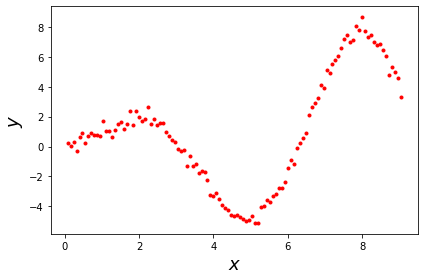

In [ ]:
def simple_plot(x, y, color,xlabel):
  plt.scatter(x, y, marker='.',color=color)
  plt.xlabel(xlabel,size=18)
  plt.ylabel('$y$',size=18)
  plt.tight_layout()

simple_plot(x_original, y_original, 'red','$x$')
#plt.savefig(folder+'gp-1.png')
plt.show()
plt.close()

<span style='color:Red'> First, we will use sklearn.

<span style='color:Green'> Let's first see what happens if don't regularize regression (we should expect the model to fit the noise)

(113,) (113, 1)


Text(0, 0.5, '$y$')

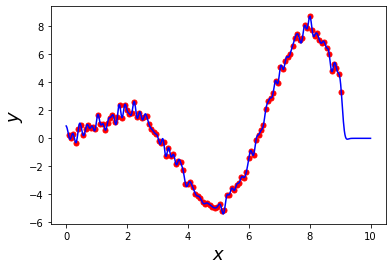

In [ ]:
# These are our data:
x_training = np.array(x_original)
y_training = np.array(y_original)
x_input = x_training.reshape(-1,1)

print(y_training.shape, x_input.shape)

x_test = np.linspace(0, 10, 1000).reshape(-1,1)

# Define the Gaussian Process model (i.e. define the kernels)
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Train the model
gp.fit(x_input, y_training)

# Make the prediction (note the two outputs: mean and variance)
y_pred, sigma = gp.predict(x_test, return_std=True)

#Plot the function, the prediction and the 95% confidence interval based on the MSE
plt.figure()
plt.plot(x_original, y_original, 'r.', markersize=10, label='Observations')
plt.plot(x_test, y_pred, 'b-', label='Prediction')
#plt.fill(np.concatenate([x_test, x_test[::-1]]),       # uncomment these lines if you'd'like the confidence interval 
#         np.concatenate([y_pred - 1.9600 * sigma,
#                        (y_pred + 1.9600 * sigma)[::-1]]),
#         alpha=.5, fc='g', label='95% confidence interval')
plt.xlabel('$x$', size=18)
plt.ylabel('$y$',size=18)
#plt.savefig(file_directory_path+'gp-2.png')

<span style='color:Green'> Let's now include white kernel into the kernel. 

<span style='color:Green'> Note how we build a kernel as a linear combination of two kernels.



(113,) (113, 1)


Text(0, 0.5, '$y$')

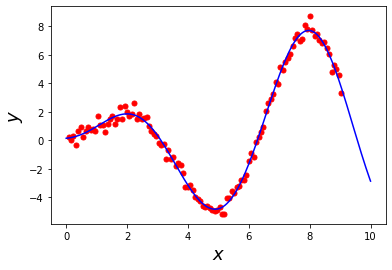

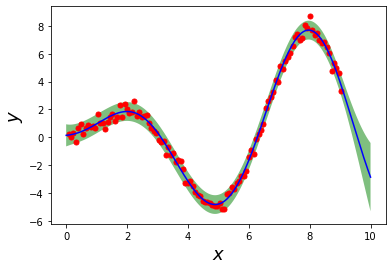

In [ ]:
# To model noise, we will add WhiteKernel to the kernel

# These are our data:
x_training = np.array(x_original)
y_training = np.array(y_original)
x_input = x_training.reshape(-1,1)

print(y_training.shape, x_input.shape)

x_test = np.linspace(0, 10, 1000).reshape(-1,1)

# Define the Gaussian Process model (i.e. define the kernels)
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Train the model
gp.fit(x_input, y_training)

# Make the prediction (note the two outputs: mean and variance)
y_pred, sigma = gp.predict(x_test, return_std=True)

# Plot the results
plt.figure()
plt.plot(x_original, y_original, 'r.', markersize=10, label='Observations')
plt.plot(x_test, y_pred, 'b-', label='Prediction')
plt.xlabel('$x$', size=18)
plt.ylabel('$y$',size=18)
#plt.savefig(file_directory_path+'gp-3.png')

plt.figure()
plt.plot(x_original, y_original, 'r.', markersize=10, label='Observations')
plt.plot(x_test, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_test, x_test[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='g', label='95% confidence interval')
plt.xlabel('$x$', size=18)
plt.ylabel('$y$',size=18)
#plt.savefig(file_directory_path+'gp-4.png')

<span style='color:Green'> We will now build GP regression of the same data using tensorflow


In [ ]:
# These are our data:
x_training = np.array(x_original)
y_training = np.array(y_original)
x_input = x_training.reshape(-1,1)  # Note that we need to reshape the input data for 1D problems
data_noise_variance=.1

number_training_points=x_input.shape[0]
print(number_training_points)

113



Check the following API we will be using here:  
   > tfp.distributions.GaussianProcess(\
   >      kernel, index_points=None, mean_fn=None, observation_noise_variance=0.0,\
   >      marginal_fn=None, jitter=1e-06, validate_args=False, allow_nan_stats=False,\
   >      name='GaussianProcess')


In [ ]:
def build_gp(amplitude, length_scale, data_noise_variance):
  """Defines the conditional distribution of GP outputs, given kernel parameters."""

  # Create the covariance kernel
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)  # <---tfk = tfp.math.psd_kernels

  # Create the GP prior distribution, which we will use to train the model
 
  return tfd.GaussianProcess(            # <----- tfd = tfp.distributions
      kernel=kernel,
      index_points=x_input,
      observation_noise_variance=data_noise_variance)


gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'data_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

In [ ]:
#Uncomment the following four lines to see if sampling from the prior works:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)
print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

In [ ]:
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

data_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='data_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       data_noise_variance_var]]

print(trainable_variables)

[<tf.Variable 'amplitude:0' shape=() dtype=float64, numpy=0.0>, <tf.Variable 'length_scale:0' shape=() dtype=float64, numpy=0.0>, <tf.Variable 'data_noise_variance_var:0' shape=() dtype=float64, numpy=0.0>]


In [ ]:
#@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, data_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'data_noise_variance': data_noise_variance,
      'observations': y_training
  })
print(amplitude_var)

<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=1.0>


In [ ]:
# Now we optimize the model parameters (it may take a couple of minutes.. so get a cup of coffee and relax).
num_iters = 500
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Store the likelihood values during training. We will plot it vs iteration number next
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            data_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
#  tf.print(loss, trainable_variables)
#  tf.print('Iteration #', i,'  Loss = - target_log_probability: ', loss)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('data_noise_variance: {}'.format(data_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 3.363495908719016
length_scale: 1.4669505199661481
data_noise_variance: 0.11353763211175058


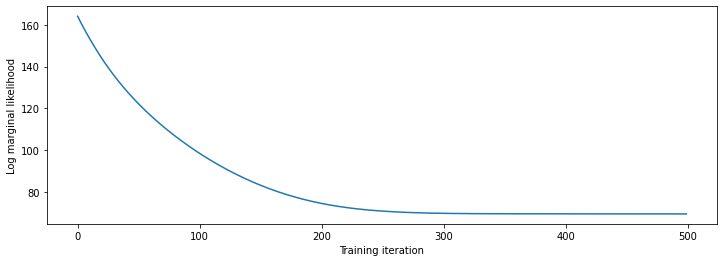

In [ ]:
# Plot the loss evolution with optimization of hyperparameters
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()


  Check the following API we will be using here:

> tfp.distributions.GaussianProcessRegressionModel(\
>    kernel, index_points=None, observation_index_points=None, observations=None,\
>    observation_noise_variance=0.0, predictive_noise_variance=None, mean_fn=None,\
>    jitter=1e-06, validate_args=False, allow_nan_stats=False,\
>    name='GaussianProcessRegressionModel')
> 

# Task 1
Extend the code below to build a GP model of a 6D PES for the molecule H3O+. The potential energy points are in the file H3O+.csv (with six first columns listing the coordinates and the seventh -- the energy). Use 1000 randomly selected training points to build the models.

In [ ]:
# Now - since we have the optimal kernel parameters - we have the model, which a GP - a distribution of functions. 
# Let's sample from the GP posterior conditioned on our training data

# We need to sample at points other than the training inputs.
# Above we generated x_test: the positions of the test points. We will be using them as inputs into GPModel

test_inputs = x_test

#tf.print('Optimal kernel parameters: ', amplitude_var, length_scale_var)
optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)  #  <--- generate the kernel 
                                                                                #  with the optimal parameters
gprm = tfd.GaussianProcessRegressionModel(    # <--- this is from tfd = tfp.distributions
    kernel=optimized_kernel,
    index_points=test_inputs,
    observation_index_points=x_input,
    observations=y_training,
    observation_noise_variance=data_noise_variance_var,
    predictive_noise_variance=0.)


# Draw num_samples independent samples, each of which is a *joint* draw
# from the posterior at the index_points = test_inputs. Since we have 113 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 113-dimensional multivariate Gaussian distribution!
num_samples = 100
samples = gprm.sample(num_samples)

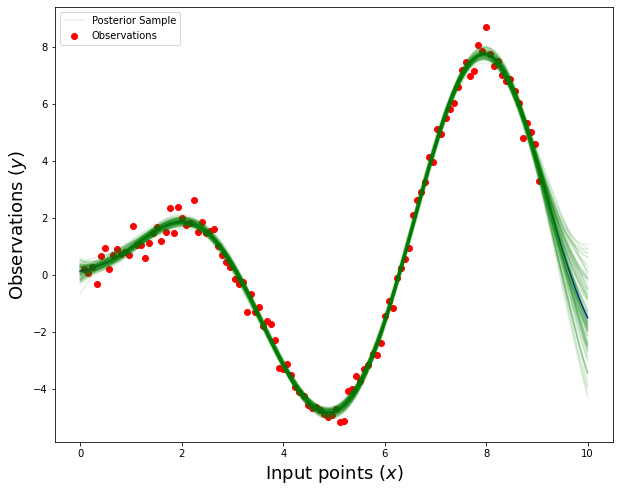

In [ ]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(10, 8))
plt.scatter(x_training, y_training, c='r',
            label='Observations')
plt.plot(test_inputs, np.mean(samples, axis=0), c='b')
for i in range(num_samples):
  plt.plot(test_inputs, samples[i, :], c='g', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper left')
plt.xlabel(r"Input points ($x$)",size=18)
plt.ylabel("Observations ($y$)",size=18)
#plt.savefig(file_directory_path+'gp-1.png')
plt.show()

## Your code of GPR for 6D PES of $H_3O^+$

In [ ]:
# If you chose to clone GitHub repo:
!git clone https://github.com/Shmoo137/SummerSchool2021_MLinQuantum
folder = "/content/SummerSchool2021_MLinQuantum/B - Gaussian Process Regression (by Roman Krems)/"

Cloning into 'SummerSchool2021_MLinQuantum'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 21 (delta 7), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [ ]:
# Import your training data:
# six first columns list the coordinates and the seventh - the energy
from numpy import genfromtxt
data = genfromtxt(folder + 'H3O+.csv', delimiter=',')

In [ ]:
print(data.shape)

(31509, 7)


In [ ]:
# Choose randomly 1000 data to be your training data
chosen_training_indices = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
rest = np.setdiff1d(np.arange(data.shape[0]),chosen_training_indices)

In [ ]:
x_training = data[chosen_training_indices][:,:6]
y_training = data[chosen_training_indices][:,6]

print("x_training.shape", x_training.shape)
print("y_training.shape", y_training.shape)

x_test = data[rest][1:,:6]
y_test = data[rest][1:,6]

print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

x_input = x_training

x_training.shape (1000, 6)
y_training.shape (1000,)
x_test.shape (30508, 6)
y_test.shape (30508,)


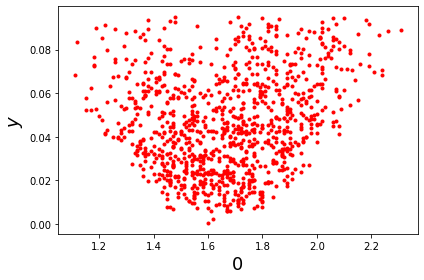

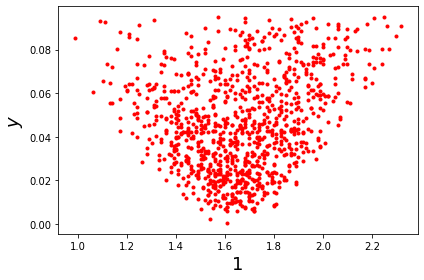

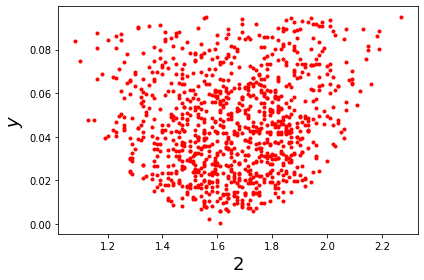

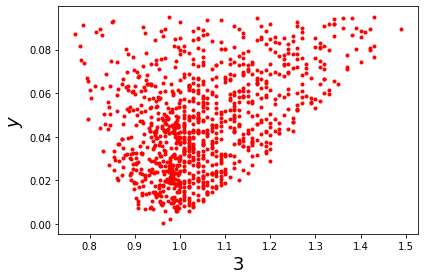

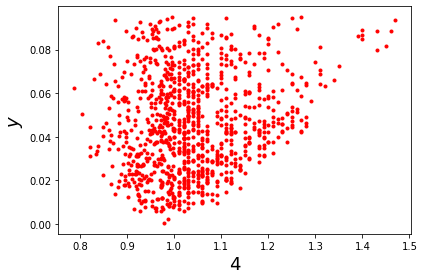

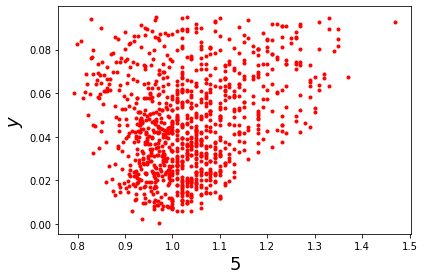

In [ ]:
for which_column in range(6):
  plt.figure()
  plt.scatter(x_training[:,which_column], y_training, marker='.',color='red')
  plt.xlabel(str(which_column),size=18)
  plt.ylabel('$y$',size=18)
  plt.tight_layout()
  plt.show()
  plt.close()

In [ ]:
# Let's have a model with regularization immediately

# Define the Gaussian Process model (i.e. define the kernels)
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel() # WhiteKernel models the noise
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Train the model
gp.fit(x_input, y_training)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [ ]:
# Make the prediction (note the two outputs: mean and variance)
y_pred, sigma = gp.predict(x_test, return_std=True)

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error, mean_absolute_error, explained_variance_score
def regression_metrics(y_test, y_pred):
  print("R2\t\t\tMedAE\t\t\tMSE\t\t\t\tMAE\t\t\tEVS")
  print(r2_score(y_test, y_pred, multioutput='uniform_average'), "\t", median_absolute_error(y_test, y_pred), "\t", mean_squared_error(y_test, y_pred), "\t", mean_absolute_error(y_test, y_pred), "\t", explained_variance_score(y_test, y_pred))


In [ ]:
regression_metrics(y_test, y_pred)

R2			MedAE			MSE				MAE			EVS
0.9931918156567808 	 0.0009354408852203025 	 3.468145244567462e-06 	 0.0012669781870719005 	 0.9932019134099084


In [ ]:
# Check for overfitting
y_pred_training, sigma_training = gp.predict(x_training, return_std=True)
regression_metrics(y_training, y_pred_training)

R2			MedAE			MSE				MAE			EVS
0.9965345027288475 	 0.0007665224423675683 	 1.7319258973085463e-06 	 0.0009739555204110491 	 0.996534502730104


# Task 2
Build the model with four different simple kernels as provided by sklearn (read [this](https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels)).

In [ ]:
# Build the model with four different simple kernels as provided by sklearn
def GPR(kernel, x_input, y_training, x_test, y_test):
  # Define the Gaussian Process model (i.e. define the kernels)
  gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

  # Train the model
  print(x_input.shape, y_training.shape)
  gp.fit(x_input, y_training)

  # Make the prediction (note the two outputs: mean and variance)
  print("Test accuracy")
  y_pred, sigma = gp.predict(x_test, return_std=True)
  regression_metrics(y_test, y_pred)

  # Check for overfitting
  print("Training accuracy")
  y_pred_training, sigma_training = gp.predict(x_training, return_std=True)
  regression_metrics(y_training, y_pred_training)



In [ ]:
GPR(kernel, x_input, y_training, x_test, y_test)

(1000, 6) (1000,)
Test accuracy
R2			MedAE			MSE				MAE			EVS
0.9853317317156103 	 0.0010750033878304758 	 7.472136818271259e-06 	 0.001698432771651935 	 0.9853809030840719
Training accuracy
R2			MedAE			MSE				MAE			EVS
0.9973416182384933 	 0.0006165616566306195 	 1.3285597585119338e-06 	 0.0008225759002142548 	 0.997341618239355


In [ ]:
from sklearn.gaussian_process.kernels import RationalQuadratic
kernel = RationalQuadratic() + WhiteKernel()
GPR(kernel, x_input, y_training, x_test, y_test)

Test accuracy
R2			MedAE			MSE				MAE			EVS
0.9935441140144778 	 0.000884890551883474 	 3.2886815561124364e-06 	 0.0012221305016820695 	 0.9935534669375627
Training accuracy
R2			MedAE			MSE				MAE			EVS
0.996984834025334 	 0.0006905194527023033 	 1.5068671615115633e-06 	 0.0009013376174688175 	 0.9969848340308306


In [ ]:
from sklearn.gaussian_process.kernels import Matern
kernel = Matern() + WhiteKernel()
GPR(kernel, x_input, y_training, x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Test accuracy
R2			MedAE			MSE				MAE			EVS
0.9853317339628471 	 0.0010750033703227028 	 7.4721356735102816e-06 	 0.0016984326226714753 	 0.9853809053242039
Training accuracy
R2			MedAE			MSE				MAE			EVS
0.9973416196357188 	 0.0006165614397161331 	 1.3285590602309366e-06 	 0.0008225756952132395 	 0.9973416196365804


# Task 3
Improve the generalization accuracy of the models built in 1 by building more complex kernels using the Bayesian Information Criterion (BIC) as model selection metric (as described in lectures). Plot the generalization error as a function of kernel complexity.

Let's remind ourselves what is the BIC.
$$
\mathrm{BIC} = -2 \,\mathrm{loglik} + d\,\log(n),
$$
where $\mathrm{loglik}$ is the maximum value of the log likelihood, $d$ is the number of parameters, and $n$ is the number of training points. When having $\mathrm{BIC}$, we can estimate and compare the posterior probability of each model $\mathcal{M}_m$:
$$
\mathcal{M}_m = \frac{e^{-\frac{1}{2} \mathrm{BIC}_m}}{\mathcal{N}},
$$
where $\mathcal{N} = \sum_{l=1}^M e^{-\frac{1}{2} \mathrm{BIC}_l}$ with $M$ being the number of compared models. Finally, we can calculate the BIC in the limit of large $n$ which makes the formula much easier to compute. What is really nice, is that even though we calculated it for the large limit, it works also pretty well for small $n$!
$$
\mathrm{BIC}_{\mathrm{large}\,n} = \mathrm{LML}_{\mathrm{GPR}} - \frac{d}{2}\,\log(n),
$$
where $d$ is again the number of kernel parameters and $\mathrm{LML}$ is the [log-marginal-likelihood](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.log_marginal_likelihood). Remember what is the meaning of LML?


It's the probability of training outputs/labels $y$ at the locations of the input space indicated by $X$. We maximize it within the GPR training, and the formula is the following:
$$
p(y|X) = \int_θ p(y|θ, X) \,p(θ|X) \,dθ,
$$
where the model likelihood $p(y|θ, X)$ (so likelihood of getting training ouputs given the model parameters and training onputs) is multiplied by $p(θ|X)$ (unconditional (prior) probability of $\theta$ at the locations of the input space indicated by $X$) and integrates over all random function values $\theta$. By this integration, we're *marginalizing* the variable $\theta$, hence the name.

Bonus question: do you remember the difference between the likelihood and probability? ;)
